In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Loading (remote) E-OBS observations and summer days (SU) calculation

Git repo: https://github.com/rmsryu/spark-climate-data.git
Data set: https://www.ecad.eu/download/ensembles/download.php

E-OBS data is loaded from the remote OpenDAP repository at KNMI. Please, note that when new versions become available the link is no longer valid since the URL is updated with the version number. Therefore, if the code below doesn't work please check the current E-OBS version and update the URL (https://www.ecad.eu/download/ensembles/download.php). 

# Study of daily precipitation from Station Aalsmeer Netherlands
Data source: https://climexp.knmi.nl/data/rrrr458.dat
Data provide by: Royal Netherlands Meteorological Institute (KNMI)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql.types import *
from pyspark.sql.functions import *



In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data load from

In [4]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'

In [5]:
def get_final_data(freq, filter_year = 1951):
    data_files = f'{hadoopUrl}/precipitation/data/agg/final/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

def get_specific_station_data(station, freq, filter_year = 1951):
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df = df[df.index.year > filter_year] # Only 1951 onwards
    
    if(freq != 'd'):
        # Set the frequency data set
        df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

In [6]:
data_files = f'{hadoopUrl}/precipitation/data/*/*.parquet'
# Obtain dataset
data = spark.read.parquet(data_files)
data = data.withColumn("precipitation", col("precipitation").cast("float"))
data = data.withColumn("date", col("date").cast("date"))
data.createOrReplaceTempView("precipitations")
data.cache()

# Read Station Info
schema_stations = StructType([
        StructField("station", StringType(), True),
        StructField("name", StringType(), True),
        StructField("latitude", FloatType(), True),
        StructField("longitude", FloatType(), True),
        StructField("website", StringType(), True),
        StructField("rawdata", StringType(), True),
        StructField("filename", StringType(), True),
        StructField("from", StringType(), True),
        StructField("to", StringType(), True)
    ])
station_files = 'hdfs://hadoop-vm.internal.cloudapp.net:9000/precipitation/data/stations/*.csv'
stations = spark.read.csv(station_files,schema=schema_stations)
stations.withColumn("from", col("from").cast("date"))
stations.withColumn("to", col("to").cast("date"))
stations.createOrReplaceTempView("stations")


In [7]:
data.summary().show()

+-------+------------------+-----------------+
|summary|           station|    precipitation|
+-------+------------------+-----------------+
|  count|          13120148|         13120148|
|   mean|483.02698064076714| 2.13989743152896|
| stddev|287.72368836944077|4.339730993138887|
|    min|               001|              0.0|
|    25%|             228.0|              0.0|
|    50%|             466.0|              0.1|
|    75%|             737.0|              2.4|
|    max|               983|            208.0|
+-------+------------------+-----------------+



In [8]:
stations.show()

+-------+--------------------+--------+---------+--------------------+--------------------+------------+----------+----------+
|station|                name|latitude|longitude|             website|             rawdata|    filename|      from|        to|
+-------+--------------------+--------+---------+--------------------+--------------------+------------+----------+----------+
|    458|            Aalsmeer|   52.25|     4.77|https://climexp.k...|https://climexp.k...|rrrr458.data|1927-01-02|2023-03-10|
|    040|   Aalsum bij Dokkum|  -999.9|   -999.9|https://climexp.k...|https://climexp.k...|rrrr040.data|1892-12-29|1925-09-30|
|    680|              Aalten|    51.9|     6.55|https://climexp.k...|https://climexp.k...|rrrr680.data|1904-08-02|2023-03-10|
|    711|          Aardenburg|  -999.9|   -999.9|https://climexp.k...|https://climexp.k...|rrrr711.data|1873-12-01|1887-06-30|
|    572|             Abcoude|   52.25|     4.97|https://climexp.k...|https://climexp.k...|rrrr572.data|1930-09

# Stations stats

In [9]:
spark.sql("SELECT station,\
              year(min(date)) min_year, \
              year(max(date)) - year(min(date)) num_years, \
              count(precipitation) count,\
              mean(precipitation) mean, \
              stddev(precipitation) stddev, \
              min(precipitation) min, \
              percentile(precipitation,0.25) 25pct, \
              percentile(precipitation,0.50) 50pct, \
              percentile(precipitation,0.75) 75pct, \
              max(precipitation) max \
            FROM precipitations GROUP BY station ORDER BY station").show()

+-------+--------+---------+-----+------------------+------------------+---+-----+-------------------+------------------+-----+
|station|min_year|num_years|count|              mean|            stddev|min|25pct|              50pct|             75pct|  max|
+-------+--------+---------+-----+------------------+------------------+---+-----+-------------------+------------------+-----+
|    001|    1940|       83|29556| 2.174519556030149| 4.370148656161713|0.0|  0.0|0.10000000149011612|               2.5| 76.6|
|    003|    1902|       51|18482|2.0838329184571815| 4.277456332945257|0.0|  0.0|0.10000000149011612| 2.299999952316284| 78.4|
|    004|    1904|        1|  419| 1.617899758558996|3.4800441747162214|0.0|  0.0|0.10000000149011612| 1.399999976158142| 26.9|
|    006|    1905|       38|13970|1.7968360776213679| 3.740703703355201|0.0|  0.0|0.10000000149011612| 1.899999976158142| 82.1|
|    007|    1906|       44|15101|1.9131845566100272|3.8756137261021313|0.0|  0.0|                0.0| 2

# Reliabality

To create a relevant and reliable dataset for average precipitation the following will be considered:

**Data selection**: Focus on the period with the most comprehensive and consistent data choosing a time frame when a higher number of weather stations are available.

**Handling missing data**: For stations with missing data or long gaps consider remove or imputate missing values.

**Temporal trends**: Analyze the dataset for any systematic temporal trends (e.g., increasing or decreasing precipitation over the years). 

**Weighting**: Contribution of each station based on factors like the length of the available data, the quality of the measurements, or the spatial coverage. Spatial coverage per station is 10Km

**Spatial coverage**: Stations spread homogenusly on the Netherland area. Some of stations do not include spatial information. 


In [10]:
from functools import reduce
from operator import add

def find_desired_year_stations(minimum_year = 1978, min_desired_data_points_per_year = 360):    
    # Get stations grouped by year and calculate desired number of records per year
    stations_years_complete  = spark.sql(f"SELECT station, year(date) year, count(precipitation) pre_year FROM precipitations where year(date) >= {minimum_year} GROUP BY station, year(date)")
    stations_years_complete = stations_years_complete.filter(col("pre_year") > min_desired_data_points_per_year)
    stations_years_complete = stations_years_complete.select("station","year").orderBy("station","year")

    # Group by 'station' and pivot on 'year'
    df_transposed = stations_years_complete.groupBy("station").pivot("year").avg("year")

    # Count the number of non null years per station
    year_columns = df_transposed.columns[1:]
    
    # expresion to filter year column not null
    count_years_expr = reduce(add, [when(col(year_col).isNotNull(), 1).otherwise(0) for year_col in year_columns])
    df_transposed = df_transposed.withColumn("total_years", count_years_expr)

    # print(f"Looking for stations with years {len(year_columns)}")
    stations_for_analysis = df_transposed.filter(col("total_years") == len(year_columns)).select("station","total_years")
    stations_filter = [item.station for item in stations_for_analysis.collect()]
    # print(f"A total of {len(stations_filter)} stations to be included")
    
    return stations_filter


## Is it possible to obtain stations with continuous observations over the longest period of time?

Locate stations that have a minimum of 360 observations annually, and identify the number of years with complete data for analysis. Exclude stations that have significant gaps in their data. Considering the consistent availability of stations since 1950, the investigation will focus on this period to maximize the number of useful stations for our analysis.

### Station must have > 360 daily observations per year
### Station must have signifiat number of complet years

In [11]:
starting_years = np.arange(1950, 1960)
# Iterate to find best year
year_list = []
result = []
best_num_of_stations = 0
for year in starting_years:
    temp = len(find_desired_year_stations(year, 360))
    result.append((year,temp))
    best_initial_year =  year if (temp > best_num_of_stations) else best_initial_year
    best_num_of_stations =  temp if (temp > best_num_of_stations) else best_num_of_stations

{"@version":1,"source_host":"rmsryu-vm","message":"Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.","thread_name":"Thread-4","@timestamp":"2023-04-08T18:33:28.501+0000","level":"WARN","logger_name":"org.apache.spark.sql.catalyst.util.package"}


In [12]:
result

[(1950, 132),
 (1951, 144),
 (1952, 150),
 (1953, 156),
 (1954, 174),
 (1955, 179),
 (1956, 188),
 (1957, 204),
 (1958, 212),
 (1959, 218)]

In [13]:
# Link candidate year
candiate_min_year = 1955
# Selecting year 1955 as baseline with 179 station complete stations datasets and minimum 360 observations
stations_filter = find_desired_year_stations(candiate_min_year, 360)

### Examination of the homogeneity and reliability of the chosen stations

In [14]:
data_1 = data.filter(data.station.isin(stations_filter))
data_1.createOrReplaceTempView("final_ds")
df_final = spark.sql(f"SELECT date, avg(precipitation) precipitation, count(precipitation) w from final_ds where year(date) > {candiate_min_year} group by date")
df_final.summary().show()

+-------+-------------------+-------------------+
|summary|      precipitation|                  w|
+-------+-------------------+-------------------+
|  count|              24541|              24541|
|   mean| 2.2576964836099185| 178.99690314168126|
| stddev|  3.513736968249654|0.07864081706020871|
|    min|                0.0|                177|
|    25%|0.03240223528619585|                179|
|    50%| 0.6435754158476877|                179|
|    75%|  3.143575413183793|                179|
|    max|  45.87486042257128|                179|
+-------+-------------------+-------------------+



### Minimize the impact of heavy rainfall and seasonality by averaging monthly data in the dataset.

The aim is to employ monthly aggregation as a means of mitigating the influence of random weather precipitation fluctuations and accounting for seasonality patterns

In [15]:
grouped_df = spark.sql("SELECT station,\
              month(date) month, \
              count(precipitation) count,\
              mean(precipitation) mean, \
              stddev(precipitation) stddev, \
              min(precipitation) min, \
              percentile(precipitation,0.25) 25pct, \
              percentile(precipitation,0.50) 50pct, \
              percentile(precipitation,0.75) 75pct, \
              max(precipitation) max \
            FROM final_ds GROUP BY station, month(date) ORDER BY station, month(date)")

grouped_df.show()

+-------+-----+-----+------------------+------------------+---+-----+-------------------+------------------+-----+
|station|month|count|              mean|            stddev|min|25pct|              50pct|             75pct|  max|
+-------+-----+-----+------------------+------------------+---+-----+-------------------+------------------+-----+
|    010|    1| 4433|1.9527633662450914| 3.311182259747489|0.0|  0.0|0.30000001192092896| 2.700000047683716| 31.5|
|    010|    2| 4066|1.5882439720226782|2.9570362632637512|0.0|  0.0|0.10000000149011612|               2.0| 24.6|
|    010|    3| 4501|1.4217951565209535| 2.936976218691808|0.0|  0.0|                0.0|               1.5| 46.1|
|    010|    4| 4350|1.3015632181469052|2.9381635539736197|0.0|  0.0|                0.0|1.2000000476837158| 32.3|
|    010|    5| 4495|1.4266740825835271|3.3174979371609443|0.0|  0.0|                0.0|1.2000000476837158| 36.5|
|    010|    6| 4320|1.8109259238294153| 4.371482022630732|0.0|  0.0|           

### Comparison of candidates stations

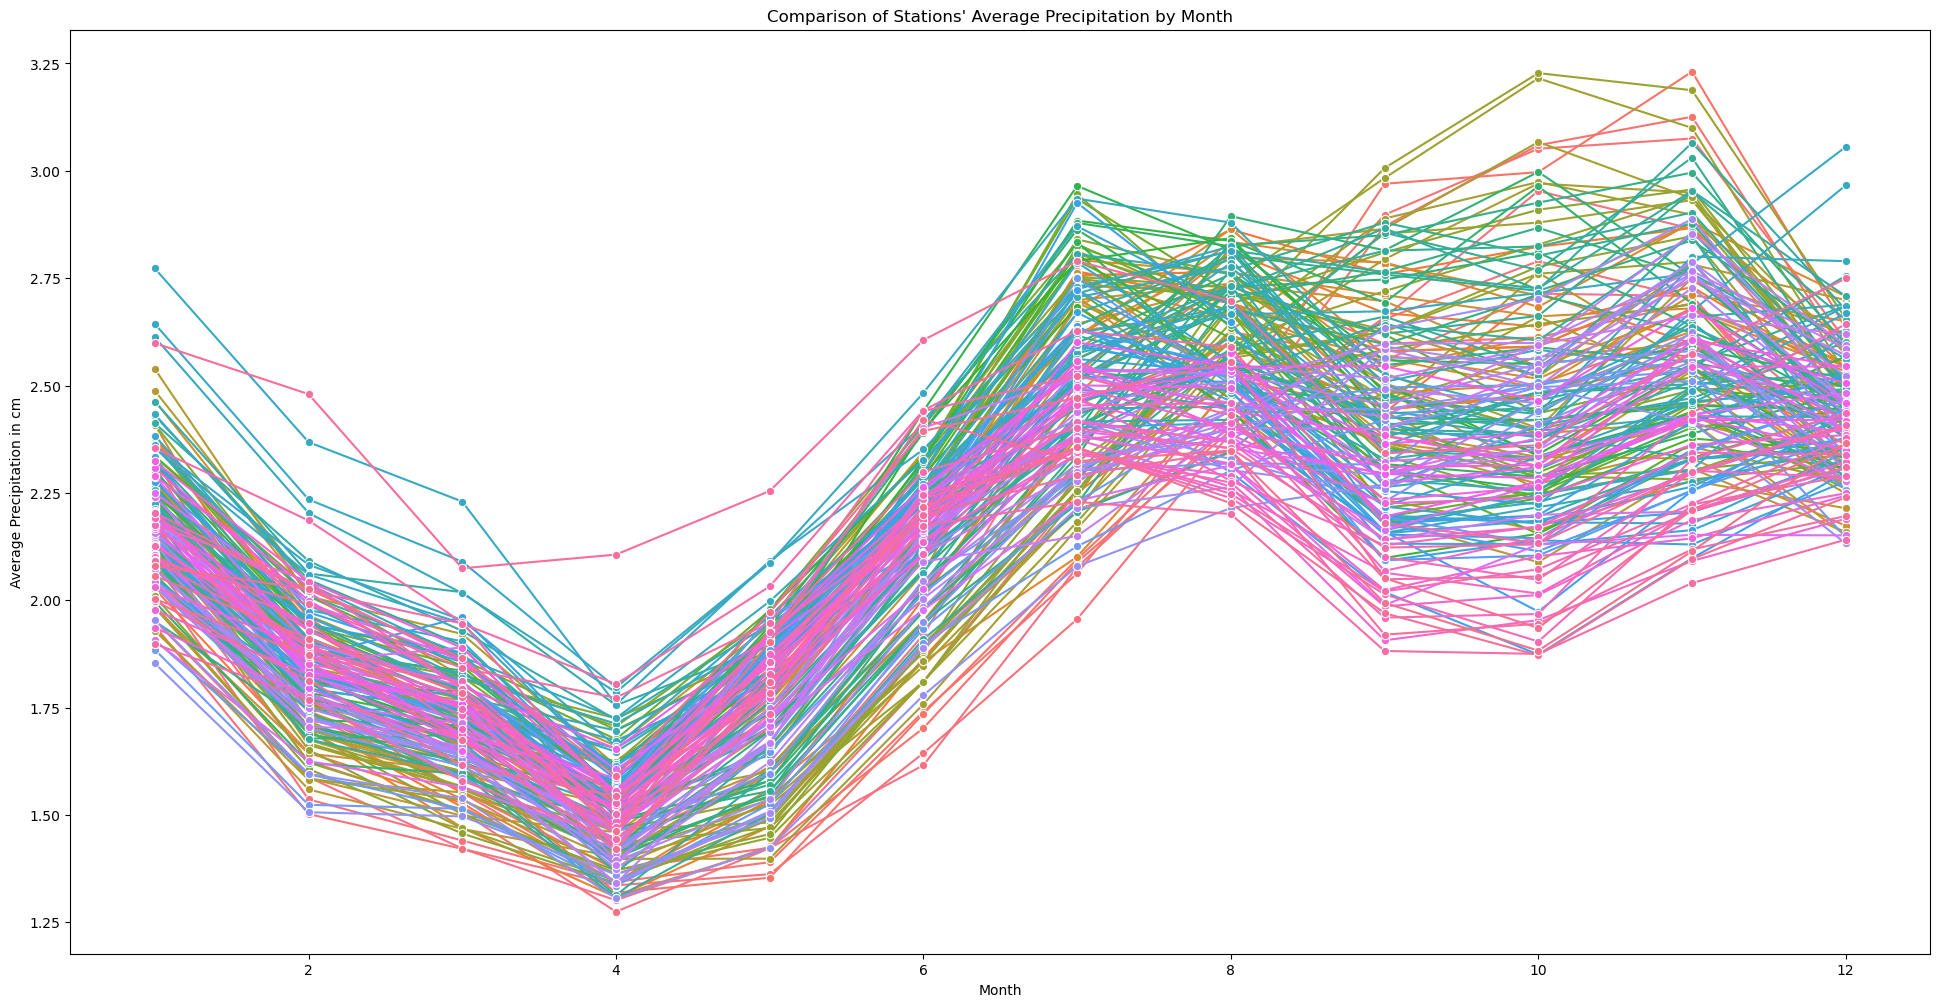

In [16]:
import seaborn as sns
# Create the line plot with multiple lines
plt.figure(figsize=(24, 12))
sns.lineplot(data=grouped_df.toPandas(), x="month", y="mean", hue="station", marker="o", legend=False)

plt.title("Comparison of Stations' Average Precipitation by Month")
plt.xlabel("Month")
plt.ylabel("Average Precipitation in cm")
plt.show()

### Viability for Station 235 

#### Monthly statistics

In [17]:
station = 235
spark.sql(f"SELECT station,\
              month(date) month, \
              count(precipitation) count,\
              mean(precipitation) mean, \
              stddev(precipitation) stddev, \
              min(precipitation) min, \
              percentile(precipitation,0.25) 25pct, \
              percentile(precipitation,0.50) 50pct, \
              percentile(precipitation,0.75) 75pct, \
              max(precipitation) max \
            FROM final_ds where station = '{station}' GROUP BY station, month(date) ORDER BY station, month(date)").show()

+-------+-----+-----+------------------+------------------+---+-----+-------------------+------------------+----+
|station|month|count|              mean|            stddev|min|25pct|              50pct|             75pct| max|
+-------+-----+-----+------------------+------------------+---+-----+-------------------+------------------+----+
|    235|    1| 2975| 2.333546217549749|3.9399789081135888|0.0|  0.0|                0.5|               3.0|35.0|
|    235|    2| 2712|1.8324483811064105|3.5204961756814326|0.0|  0.0|0.20000000298023224| 2.200000047683716|44.2|
|    235|    3| 2955| 1.658206431408824| 3.381442475710579|0.0|  0.0|0.10000000149011612|1.7999999523162842|38.0|
|    235|    4| 2850|1.4651578942830104|3.1118333037562693|0.0|  0.0|                0.0| 1.399999976158142|34.6|
|    235|    5| 2945| 1.539694397791537| 3.526003456062775|0.0|  0.0|                0.0|1.2000000476837158|43.0|
|    235|    6| 2850| 1.857508773257335| 4.681195608979129|0.0|  0.0|                0.0

#### Null values

In [18]:
spark.sql(f"SELECT count(date) FROM final_ds where station = '{station}' and precipitation is not null").show()

+-----------+
|count(date)|
+-----------+
|      34951|
+-----------+



#### Has all desired characteristics

In [19]:
if '235' in stations_filter:
    display(HTML(f"<h5>Station {station} has all desired charactateristics.</h5>"))

NameError: name 'HTML' is not defined

### RNN study of the individual stations here selected
Sequential Data: OK
Consistent Time Intervals: Fail in some stations
No missing values: a maximum of 5 missing records on the daily dataset are permited as per selection of the station. Later aggregations will absorve those missing values.

Visualization of the comparison of stations' average precipitation by month using line plot with multiple lines, where each line represents a station.

A good way to visualize the comparison of stations average precipitation by month is to use a line plot with multiple lines, where each line represents a station. I also want to select stations that has similar characterisics.
For this we can calculate the average monthly of all stations, and only select those stations that have a similar monthly average.

This way, you can easily observe the monthly trends in average precipitation for each station.

We will use as well previous list of stations calculated on LSTM results:

{'080': 0.13211404, '338': 0.13322017, '345': 0.13900559, '354': 0.14207321, '666': 0.14214464, '353': 0.14426473, '674': 0.14492266, '681': 0.14619893, '156': 0.14652579, '456': 0.14702083, '358': 0.14910142, '464': 0.14910223, '453': 0.1496602, '328': 0.1507474, '680': 0.15163502, '438': 0.15331575, '161': 0.1533159, '437': 0.15339538, '225': 0.1534206, '828': 0.15343612, '085': 0.15361921, '341': 0.15391526, '022': 0.1539157, '139': 0.1573842, '462': 0.1576759, '228': 0.157815, '974': 0.1589394, '352': 0.15925187, '968': 0.15925732, '542': 0.15995637, '163': 0.1640147, '843': 0.16505456, '838': 0.16531673, '463': 0.16534059, '084': 0.1673286, '970': 0.16780582, '356': 0.1683358, '588': 0.16878334, '764': 0.16919768, '915': 0.16940638, '572': 0.16954, '550': 0.16978025, '579': 0.17034939, '834': 0.1704336, '330': 0.17149243, '678': 0.1715598, '749': 0.1736844, '145': 0.17445874, '082': 0.17550059, '899': 0.17625822, '558': 0.17719354, '234': 0.17736025, '760': 0.17741859, '444': 0.1775532, '763': 0.17807491, '912': 0.18016313, '019': 0.18026893, '011': 0.18046126, '911': 0.18083245, '578': 0.18097365, '973': 0.18139952, '844': 0.18160371, '758': 0.18230926, '056': 0.18388759, '840': 0.18391009, '081': 0.18395138, '147': 0.18407458, '075': 0.18423764, '240': 0.1870525, '222': 0.18780243, '235': 0.18897787, '073': 0.19098094, '046': 0.19121893, '087': 0.19192405, '454': 0.1949879, '090': 0.19622971, '584': 0.2025461}

### Homogeinty on the means over the months and years

Applying a threshold of 7% variability on the mean values, stations close to the overall Netherlands average monthly data will be selected. A station must achieve a minimum of 10 months of homogeneity to be included in the study.

In [ ]:
threshold = 0.07  # Define a threshold in percentage to consider stations similarity
num_similar_months = 10 # Definie thershold of minimum months with similar mean per station


# Calculate the overall monthly average precipitation across all stations
overall_monthly_average = grouped_df.groupBy("month").agg(mean("mean").alias("overall_mean"))
overall_monthly_avg = grouped_df.toPandas().groupby("month")["mean"].mean() # this will be used for the bands later
overall_monthly_std = overall_monthly_avg * threshold # this will be used for the bands later


# Join the overall monthly average to the original DataFrame
joined_df = grouped_df.join(overall_monthly_average, on="month")


# Filter stations with similar monthly averages
similar_stations_df = joined_df.filter(
    (col("mean") >= col("overall_mean") * (1 - threshold)) & (col("mean") <= col("overall_mean") * (1 + threshold))
)

# Filter the DataFrame with the preselected stations (from LSTM individual runs)
lst_results = {'080': 0.13211404, '338': 0.13322017, '345': 0.13900559, '354': 0.14207321, '666': 0.14214464, '353': 0.14426473, '674': 0.14492266, '681': 0.14619893, '156': 0.14652579, '456': 0.14702083, '358': 0.14910142, '464': 0.14910223, '453': 0.1496602, '328': 0.1507474, '680': 0.15163502, '438': 0.15331575, '161': 0.1533159, '437': 0.15339538, '225': 0.1534206, '828': 0.15343612, '085': 0.15361921, '341': 0.15391526, '022': 0.1539157, '139': 0.1573842, '462': 0.1576759, '228': 0.157815, '974': 0.1589394, '352': 0.15925187, '968': 0.15925732, '542': 0.15995637, '163': 0.1640147, '843': 0.16505456, '838': 0.16531673, '463': 0.16534059, '084': 0.1673286, '970': 0.16780582, '356': 0.1683358, '588': 0.16878334, '764': 0.16919768, '915': 0.16940638, '572': 0.16954, '550': 0.16978025, '579': 0.17034939, '834': 0.1704336, '330': 0.17149243, '678': 0.1715598, '749': 0.1736844, '145': 0.17445874, '082': 0.17550059, '899': 0.17625822, '558': 0.17719354, '234': 0.17736025, '760': 0.17741859, '444': 0.1775532, '763': 0.17807491, '912': 0.18016313, '019': 0.18026893, '011': 0.18046126, '911': 0.18083245, '578': 0.18097365, '973': 0.18139952, '844': 0.18160371, '758': 0.18230926, '056': 0.18388759, '840': 0.18391009, '081': 0.18395138, '147': 0.18407458, '075': 0.18423764, '240': 0.1870525, '222': 0.18780243, '235': 0.18897787, '073': 0.19098094, '046': 0.19121893, '087': 0.19192405, '454': 0.1949879, '090': 0.19622971, '584': 0.2025461}
preselected_stations = list(lst_results.keys())
similar_stations_df = similar_stations_df.filter(col("station").isin(preselected_stations))

# Filters similar stations to stations that are constantly similar in all monhts
station_month_count = similar_stations_df.groupBy("station").count()

# Filter stations that have data for all 12 months
stations_with_all_months = station_month_count.filter(col("count") > num_similar_months).select("station")

# Convert the filtered stations DataFrame to a list
stations_with_all_months_list = [row["station"] for row in stations_with_all_months.collect()]

# Filter the similar_stations_df with the stations_with_all_months_list
similar_stations_df = similar_stations_df.filter(col("station").isin(stations_with_all_months_list))

# Convert the filtered DataFrame to a Pandas DataFrame
pd_df = similar_stations_df.toPandas()

# Create the line plot with multiple lines for the filtered stations
plt.figure(figsize=(12, 6))
sns.lineplot(data=pd_df, x="month", y="mean", hue="station", marker="o")

# Add the shaded bands for the upper and lower limits based on the standard deviation
plt.fill_between(overall_monthly_avg.index, overall_monthly_avg - overall_monthly_std, overall_monthly_avg + overall_monthly_std, color="gray", alpha=0.3)

# Add dotted lines for the upper and lower limits
plt.plot(overall_monthly_avg.index, overall_monthly_avg - overall_monthly_std, linestyle="--", color="black", alpha=0.5)
plt.plot(overall_monthly_avg.index, overall_monthly_avg + overall_monthly_std, linestyle="--", color="black", alpha=0.5)

plt.title("Comparison of Stations with Data for All Months' Average Precipitation")
plt.xlabel("Month")
plt.ylabel("Average Precipitation in cm")

# Move the legend to the right of the plot
plt.legend(title="Station", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [ ]:
data_2 = data.filter(data.station.isin(pd_df.station.unique().tolist()))
data_2.createOrReplaceTempView("final_ds_2")
df_final_daily = spark.sql(f"SELECT date, avg(precipitation) precipitation, count(precipitation) w from final_ds_2 where year(date) > {candiate_min_year} group by date")
df_final_daily.summary().show()

In [ ]:

# Step 3: Visualize the data using a histogram
plt.figure(figsize=(12, 6))
sns.histplot(df_final_daily.toPandas()["precipitation"], bins=30, kde=True)
plt.title("Histogram of Precipitation")
plt.xlabel("Precipitation in cm")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df_final_daily.show()

In [ ]:
df_final_daily = df_final_daily.withColumn("month", month(col("date")))
num_months = df_final_daily.select("month").distinct().count()
fig, axes = plt.subplots(num_months, 1, figsize=(10, 4 * num_months))

for i, ax in enumerate(axes, start=1):
    month_df = df_final_daily.filter(col("month") == i).toPandas()
    month_df = month_df[month_df.precipitation > 5]
    sns.histplot(month_df["precipitation"], bins=30, kde=True, ax=ax)
    ax.set_title(f"Histogram of Precipitation for Month {i}")
    ax.set_xlabel("Precipitation in mm")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Hadoop: Store combinded Dataset

In [ ]:
# Save to hadoop
df_final_daily.write.mode("overwrite").parquet(f"{hadoopUrl}/precipitation/data/agg/final")

# Seasonality - Combined and Station 235

In [ ]:
import pandas as pd
from IPython.display import display, HTML

def check_missing_values(df, freq = 'M', drop_null_values = True):
    # Check for nulls
    print(f"Number of null value in timeseries {df.precipitation.isnull().sum()}")
    
    if(drop_null_values & (df.precipitation.isnull().sum() > 0)):
        df = df.dropna(axis=0)

    # Check there is data all days of the timeseries
    start_date = pd.Timestamp(df.index.min())
    end_date = pd.Timestamp(df.index.max())

    # Create a date range for the entire period
    full_date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Check for missing dates
    missing_dates = full_date_range.difference(df.index)

    if not missing_dates.empty:
        print(f"There are {len(missing_dates)} missing dates in the index:")
        print(missing_dates)
    else:
        print("There are no missing dates in the index.")


# Plot series different time scales. Remove outliers
def seasonality_plots(grouped, station, freq="1D", start = '2015-01-01', end = '2023-01-01', remove_outliers = True):
    df_s = grouped[(grouped.index >= start) & (grouped.index <= end)]

    if(remove_outliers):
        # Calculate the IQR
        Q1 = df_s['precipitation'].quantile(0.25)
        Q3 = df_s['precipitation'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        # Filter out the outliers
        df_s = df_s[(df_s['precipitation'] >= lower_bound) & (df_s['precipitation'] <= upper_bound)]

    # Prepare data
    df_s['year'] = [d.year for d in df_s.index]
    df_s['month'] = [d.strftime('%b') for d in df_s.index]
    years = df_s['year'].unique()
    
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='precipitation', data=df_s, ax=axes[0])
    sns.boxplot(x='month', y='precipitation', data=df_s.loc[~df_s.year.isin([1900, 2023]), :])

    # Set Title
    axes[0].set_title(f'{station}-{freq} Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title(f'{station}-{freq} Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()
    
    
    x = df_s.index
    y1 = df_s['precipitation'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120, )
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-15, 15)
    plt.title(f'Precipitation {station}-{freq} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(df_s.index), xmax=np.max(df_s.index), linewidth=.5)
    plt.show()
    
def plot_seasonlity(df):
    from statsmodels.tsa.seasonal import seasonal_decompose
    from dateutil.parser import parse
    %matplotlib inline

    print(df.index.min)
    decomposition = seasonal_decompose(df['precipitation'], model='additive', extrapolate_trend='freq')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    # Plot the original time series
    ax1.plot(df['precipitation'], label='Original')
    ax1.legend(loc='upper left')
    ax1.set_title('Precipitation Time Series')

    # Plot the trend component
    ax2.plot(decomposition.trend, label='Trend')
    ax2.legend(loc='upper left')
    ax2.set_title('Trend Component')

    # Plot the seasonal component
    ax3.plot(decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='upper left')
    ax3.set_title('Seasonal Component')

    # Plot the residual component
    ax4.plot(decomposition.resid, label='Residual')
    ax4.legend(loc='upper left')
    ax4.set_title('Residual Component')

    plt.tight_layout()
    plt.show()
    return decomposition


## Residuals 
Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, hen there is information left in the residuals which should be used in omputing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, hen the forecasts are biased.

> Hyndman, R.J., A., G. (2018) Forecasting: Principles and Practice. 2nd edn. Monash University, Australia.

In [ ]:
def plot_autocorrelation(decomposition):
    
    ## can't plot autocorrelation for singular matrix
    if(decomposition.resid.values.sum() == 0):
        return
    
    ### Autocorrelation of residuals
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    # Calculate the histogram data (bin edges and counts)
    ax = sns.distplot(decomposition.resid, bins=12, kde=True, hist_kws={"alpha": 0.7})

    # Add labels to the histogram
    plt.xlabel('Precipitation')
    plt.ylabel('Frequency')
    plt.title('Precipitation Histogram')


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(decomposition.resid, lags=20, ax=ax1)
    plot_pacf(decomposition.resid, lags=20, ax=ax2)
    plt.show()


def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]


## Autocorrelation

In [ ]:
#station = 235
# Hyper parameters
hyper_parameters = {
    'freq' : '4W',
    'look_back' : 12
}

df_seasson = get_final_data(hyper_parameters['freq'], 1800)
#df_seasson = get_specific_station_data(station, hyper_parameters['freq'], 1951)

# Check missing values
#check_missing_values(df_seasson)


# Seasonal Analysis
display(HTML(f'<h3>Seasonal Analysis - Combined Stations</h3>'))
display(HTML('<hr/><br/>'))
seasonality_plots(df_seasson,station,hyper_parameters['freq'],remove_outliers=False)

# Decomposition Analysis
display(HTML(f'<h3>Decomposition Analysis - Combined Stations</h3>'))
display(HTML('<hr/><br/>'))
decomposition = plot_seasonlity(df_seasson)
decomposition.resid.describe()

# Plot autocorrelation
plot_autocorrelation(decomposition)


> For monthly data there Auto-correlation found for values < 5 mm

> For aggregations on 4 weeks not tight to calendar months this autocorrelation is solved bar the zeros

> Autocorrelation is high for light rain and no precipiatation

## Stationary test

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series possesses a unit root and is non-stationary.")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "<span style='background-color:red;'>NON-STATIONARY</span>" if p_value < 0.05 else "<span style='background-color:green;'>STATIONARY</span>"
    display(HTML(result))
    
    if(False): # Turn this on for KPSS test
        print("\nKPSS Test:")
        print("============")
        kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
        print(f"null_hypothesis: the time series is trend stationary")
        print(f"Test statistic: {kpss_result[0]}")
        print(f"P-value: {kpss_result[1]}")
        p_value = kpss_result[1]
        print("Critical values:")
        for key, value in kpss_result[3].items():
            print(f"{key}: {value}")

        result = "<span style='background-color:green;'>STATIONARY</span>" if p_value < 0.05 else "<span style='background-color:red;'>NON-STATIONARY</span>"
        display(HTML(result))


In [ ]:
#Montly Data
hyper_parameters['freq'] = '4w'

useCombinedDS = True

if(useCombinedDS):
    station = "Combined Stations"
    df_daily = get_final_data('d',1800)
else:
    station = 235
    df_daily = get_specific_station_data(station,'d',1800)

### Differentiation

In [ ]:
# get the daily observations and apply differentiation
df_daily["precipitation_diff"] = df_daily["precipitation"].diff().dropna()

# Set the frequency data set
df_seasson = df_daily.resample(hyper_parameters['freq']).mean()
test_stationarity(df_seasson.precipitation_diff.dropna())

### Seasonality difference

In [ ]:
# Seosonal difference
seasonal_diff = df_daily["precipitation"] - df_daily["precipitation"].shift(365)
df_daily["precipitation_seasonal_diff"] = seasonal_diff.dropna()
#test_stationarity(df_daily.precipitation_seasonal_diff.dropna())

# Set the frequency data set
df_seasson = df_daily.resample(hyper_parameters['freq']).mean()
test_stationarity(df_seasson.precipitation_seasonal_diff.dropna())

### Logaritmic transformation

In [ ]:
# get the daily observations and apply differentiation
df_daily["precipitation_log"] = np.log1p(df_daily["precipitation"])

# Set the frequency data set
df_seasson = df_daily.resample(hyper_parameters['freq']).mean()
test_stationarity(df_seasson.precipitation_log.dropna())


### Combination LOG-DIFF

In [ ]:
# get the daily observations and apply differentiation
df_daily["precipitation_log_diff"] = df_daily["precipitation_log"].diff().dropna()
#test_stationarity(df_daily.precipitation_log_diff.dropna())

# Set the frequency data set
df_seasson = df_daily.resample(hyper_parameters['freq']).mean()
test_stationarity(df_seasson.precipitation_log_diff.dropna())

### Visualize autocorrelations

high number of zero values could cause issues with your model, you can consider the following approaches:

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

dic_freq = {
    '1d': 365,
    '1w': 52,
    '4w': 13,
    'M': 12,
    '16w': 3,
    'Q': 4,
}

for k in dic_freq.keys():
    freq = k
    period = dic_freq[k]

    if(useCombinedDS):
        data = get_final_data(freq, 1800)
    else:
        data = get_specific_station_data(station,freq, 1800)


    display(HTML(f"<h3>{station}: Frequency {k}</h3>"))
    
    # Perform STL decomposition
    stl = sm.tsa.STL(data["precipitation"], period=period)
    result = stl.fit()
    # Plot autocorrelation
    plot_autocorrelation(result)


# Conclusions

> The time series data exhibits non-stationary characteristics, and efforts to eliminate autocorrelation during dry seasons were unsuccessful. Consequently, no transformations will be applied, and the models will be trained for these periods. The optimal seasonal period was determined to be monthly, based on autocorrelation plot analysis.